In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

2025-10-22 08:35:06.885401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761122107.094436      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761122107.160408      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tăng cường dữ liệu cho danh mục cattle
Tăng cường dữ liệu cho danh mục dog
Tăng cường dữ liệu cho danh mục chicken
Tăng cường dữ liệu cho danh mục elephant
Tăng cường dữ liệu cho danh mục cat


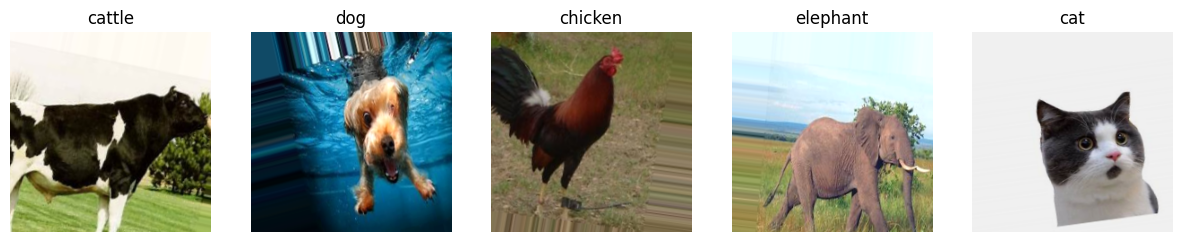

In [2]:
# Đọc và xử lý các ảnh, bao gồm cả kênh alpha

# Đường dẫn đến thư mục chứa ảnh
OUTPUT_DIR = "/kaggle/input/mydata/animals5_100"
# Danh sách các từ khóa (lớp)
keywords = ["chicken", "dog", "cat", "cattle", "elephant"]

# Đọc và xử lý ảnh
processed_images = {}
image_counts = {keyword: 0 for keyword in keywords}

for root, _, files in os.walk(OUTPUT_DIR):
    # lấy tên thư mục cha làm nhãn
    category = os.path.basename(root).lower()
    if category not in keywords:
        continue  # bỏ qua thư mục không thuộc class cần

    for filename in files:
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

            # Nếu không đọc được ảnh thì bỏ qua
            if img is None:
                print(f"Không thể đọc ảnh: {img_path}")
                continue

            # Nếu ảnh có kênh alpha (RGBA) → convert sang RGB với nền trắng
            if img.shape[-1] == 4:
                alpha_channel = img[:, :, 3]
                rgb_channels = img[:, :, :3]
                white_background = np.ones_like(rgb_channels, dtype=np.uint8) * 255
                alpha_factor = alpha_channel[:, :, np.newaxis].astype(np.float32) / 255.0
                alpha_factor = np.concatenate((alpha_factor,) * 3, axis=2)
                img = (rgb_channels.astype(np.float32) * alpha_factor +
                       white_background.astype(np.float32) * (1 - alpha_factor)).astype(np.uint8)

            # Nếu ảnh RGB hoặc Grayscale
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif len(img.shape) == 2:  # Grayscale
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # Resize ảnh về (224,224)
            img = cv2.resize(img, (224, 224))

            # Lưu vào dict
            if category not in processed_images:
                processed_images[category] = []
            processed_images[category].append(img)
            image_counts[category] += 1

# Tăng cường dữ liệu
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

augmentation_factor = 2  # nhân đôi dữ liệu
augmented_images = {}

sample_images = []

for category, images in processed_images.items():
    print(f"Tăng cường dữ liệu cho danh mục {category}")
    augmented_images[category] = images.copy()  # giữ lại ảnh gốc

    img_array = np.array(images)
    num_to_generate = len(images) * (augmentation_factor - 1)
    aug_iter = datagen.flow(img_array, batch_size=1)

    for _ in range(num_to_generate):
        aug_img = next(aug_iter)[0].astype(np.uint8)
        augmented_images[category].append(aug_img)

    sample_images.append((category, augmented_images[category][len(images)]))
    
plt.figure(figsize=(15, 3))
for i, (category, img) in enumerate(sample_images):
    plt.subplot(1, len(sample_images), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(category)
plt.show()

In [3]:
# 1. Chuẩn bị dữ liệu X và y từ processed_images (ẢNH GỐC)

X_orig = []
y_labels_orig = []

for category, images in processed_images.items():
    for img in images:
        # Ảnh đã được chuẩn hóa [0, 1] ở bước đọc ảnh
        X_orig.append(img)
        y_labels_orig.append(category)

# Chuyển thành mảng NumPy
X_orig = np.array(X_orig)
y_labels_orig = np.array(y_labels_orig)

# 2. Mã hóa nhãn
label_encoder = LabelEncoder()
y_encoded_orig = label_encoder.fit_transform(y_labels_orig)
y_one_hot_orig = to_categorical(y_encoded_orig)

class_names = label_encoder.classes_
print("Các lớp:", class_names)
print("Số lượng lớp:", len(class_names))
NUM_CLASSES = len(class_names)

# 3. Chia dữ liệu GỐC thành tập Train, Validation và Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_orig, y_one_hot_orig, test_size=0.2, random_state=42, stratify=y_one_hot_orig
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp # Val = 20% tổng thể
)

print(f"Kích thước tập huấn luyện gốc (X_train): {X_train.shape}")
print(f"Kích thước tập validation gốc (X_val): {X_val.shape}")
print(f"Kích thước tập kiểm tra gốc (X_test): {X_test.shape}")

Các lớp: ['cat' 'cattle' 'chicken' 'dog' 'elephant']
Số lượng lớp: 5
Kích thước tập huấn luyện gốc (X_train): (300, 224, 224, 3)
Kích thước tập validation gốc (X_val): (100, 224, 224, 3)
Kích thước tập kiểm tra gốc (X_test): (100, 224, 224, 3)


In [4]:
import math
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2

# 1. Định nghĩa Mô hình (EfficientNetB0
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 5  
# Tải base model EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = True
# Đóng băng tất cả các layers trừ những layers cuối
for layer in base_model.layers[:-15]:
    layer.trainable = False


x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


predictions = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 2. Biên dịch Mô hình ---
BATCH_SIZE = 32

try:
    steps_per_epoch = math.ceil(len(X_train) / BATCH_SIZE)
    validation_steps = math.ceil(len(X_val) / BATCH_SIZE)
except NameError as e:
    print(f"Lỗi: {e}")
    raise SystemExit("Dừng thực thi do thiếu dữ liệu.")
optimizer = Adam(learning_rate=1e-3) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print("--- Cấu trúc mô hình (với Generator) ---")
# model.summary()


I0000 00:00:1761122128.508255      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761122128.508997      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Cấu trúc mô hình (với Generator) ---


In [5]:
# 3. Tạo Data Generators 

# Generator cho Training Data: Augmentation + Preprocessing
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)


val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Sử dụng preprocess_input của ResNet
)

try:
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE
    )
    train_generator._set_index_array()
    val_generator = val_test_datagen.flow(
        X_val, y_val,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    print("Data Generators đã được tạo thành công.")
except NameError as e:
    print(f"Lỗi: Không tìm thấy biến dữ liệu (X_train,...). Hãy chạy lại ô chia dữ liệu. ({e})")
    raise SystemExit("Dừng thực thi do thiếu dữ liệu cho generator.")


Data Generators đã được tạo thành công.


In [6]:
#  4. Định nghĩa Callbacks 


checkpoint_filepath_eff = '/kaggle/working/best_model.keras'  
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath_eff,
    save_weights_only=False,
    monitor='val_accuracy', 
    mode='max',         
    save_best_only=True)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1)

early_stopping = EarlyStopping(
  monitor='val_loss',          
   patience=10,                 
   restore_best_weights=True,   
    verbose=1
)
# --- 5. Huấn luyện Mô hình ---
EPOCHS = 50

print(f"\nBắt đầu huấn luyện với {EPOCHS} epochs...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}\n")
steps_per_epoch = math.ceil(len(X_train) / BATCH_SIZE)
validation_steps = math.ceil(len(X_val) / BATCH_SIZE)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    
    callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping]
)

print("--- Huấn luyện hoàn tất! ---")


Bắt đầu huấn luyện với 50 epochs...
Batch size: 32
Steps per epoch: 10
Validation steps: 4



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1761122150.421137     106 service.cc:148] XLA service 0x7d31d80022c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761122150.422197     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761122150.422226     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761122152.522579     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/10 ━━━━━━━━━━━━━━━━━━━━ 4:43 32s/step - accuracy: 0.2500 - loss: 2.6560

I0000 00:00:1761122163.524208     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.4723 - loss: 1.8720 - val_accuracy: 0.9300 - val_loss: 0.6577 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - accuracy: 0.8871 - loss: 0.5514 - val_accuracy: 0.9400 - val_loss: 0.4780 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.9744 - loss: 0.3333 - val_accuracy: 0.9400 - val_loss: 0.4299 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - accuracy: 0.9824 - loss: 0.3115 - val_accuracy: 0.9500 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.9729 - loss: 0.3148 - val_accuracy: 0.9300 - val_loss: 0.3655 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.9861 - loss: 0.2951 - val_accuracy: 0.9500 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms/step - accuracy: 0.9892 - loss: 0.2862 - val_accuracy:


--- Đánh giá EfficientNetB0 trên tập test ---
Đã tải mô hình tốt nhất từ checkpoint
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9354 - loss: 0.3968

Test accuracy: 0.9400
Test loss: 0.4023


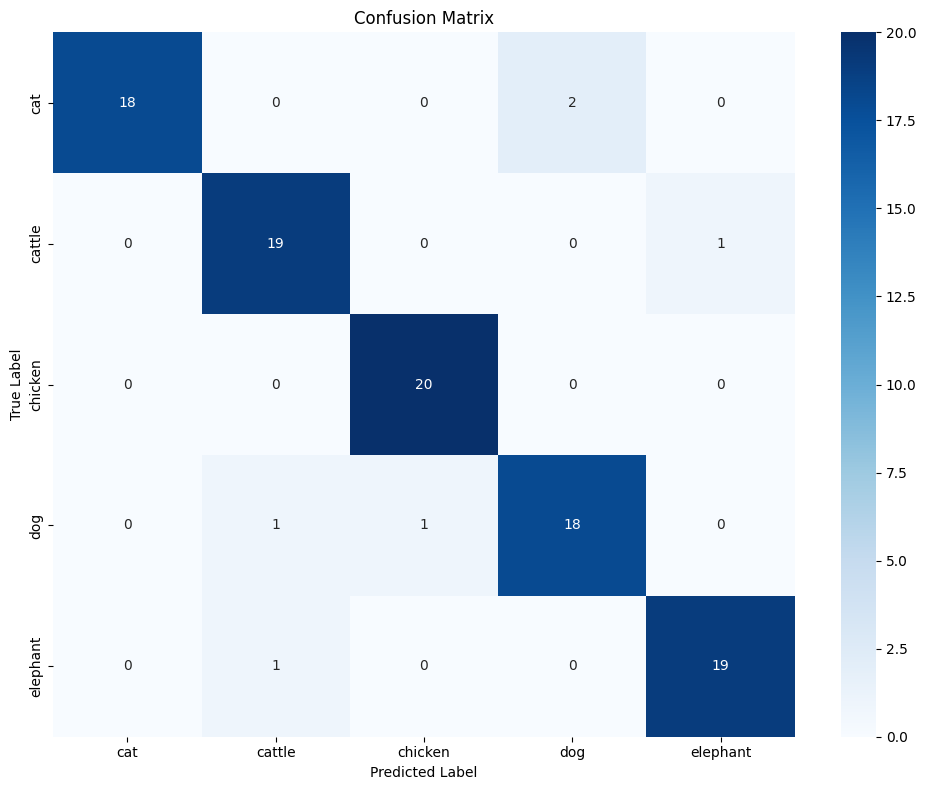


Classification Report:
              precision    recall  f1-score   support

         cat       1.00      0.90      0.95        20
      cattle       0.90      0.95      0.93        20
     chicken       0.95      1.00      0.98        20
         dog       0.90      0.90      0.90        20
    elephant       0.95      0.95      0.95        20

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [7]:
# --- 3. Ma trận nhầm lẫn và báo cáo phân loại ---
from sklearn.metrics import confusion_matrix, classification_report

# Cho EfficientNetB0
def preprocess_val_efficientnet(image, label):
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

test_dataset_efficientnet = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset_efficientnet = test_dataset_efficientnet.map(preprocess_val_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_efficientnet = test_dataset_efficientnet.batch(BATCH_SIZE)
test_dataset_efficientnet = test_dataset_efficientnet.prefetch(tf.data.AUTOTUNE)

# --- 2. Đánh giá mô hình trên tập test ---
print("\n--- Đánh giá EfficientNetB0 trên tập test ---")

# Đảm bảo load mô hình tốt nhất
checkpoint_filepath_eff = '/kaggle/working/best_model.keras' 

try:
    best_model = tf.keras.models.load_model(checkpoint_filepath_eff)
    print("Đã tải mô hình tốt nhất từ checkpoint")
except Exception as e:
    print(f"Không thể tải mô hình từ checkpoint: {e}")
    best_model = model
    print("Sử dụng mô hình hiện tại")

# Đánh giá trên tập test
test_results = best_model.evaluate(test_dataset_efficientnet, verbose=1)
print(f"\nTest accuracy: {test_results[1]:.4f}")
print(f"Test loss: {test_results[0]:.4f}")


# Dự đoán nhãn
y_pred = []
y_true = []

# Reset test_dataset để có thể lặp qua nó từ đầu
test_dataset_efficientnet = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset_efficientnet = test_dataset_efficientnet.map(preprocess_val_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset_efficientnet = test_dataset_efficientnet.batch(BATCH_SIZE)

# Lấy dự đoán và nhãn thực
for images, labels in test_dataset_efficientnet:
    preds = best_model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    
    y_pred.extend(pred_classes)
    y_true.extend(true_classes)

# Tạo confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# In classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))